## MACD Assignment Implementation

#### Import and decalre variables

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Read and clean excel file

In [3]:
# Read the excel file
df = pd.read_excel('SPY_2016_2021.xlsx', parse_dates=['Date'], index_col='Date') #please replace the file name
df = df[['Close']].dropna()
df.head()

,Close
Date,
2016-01-04,201.020004
2016-01-05,201.360001
2016-01-06,198.820007
2016-01-07,194.050003
2016-01-08,191.919998


#### Get user input for calculation type (SMA or EMA)

In [4]:
# Get user's choice
def cal_type():
    calculation = ''
    while calculation not in ['SMA', 'EMA']:
        calculation = input('Select calculation for moving average (SMA/EMA):').strip()
    return calculation
compute = cal_type()
print(f'Chosen {compute} calculaion type')

Chosen SMA calculaion type


In [5]:
new_df = df.copy()

if compute.upper() == 'SMA':
    new_df['short_ma'] = new_df['Close'].rolling(window=12).mean()
    new_df['long_ma'] = new_df['Close'].rolling(window=26).mean()
elif compute.upper() == 'EMA':
    new_df['short_ma'] = new_df['Close'].ewm(span=12, adjust=False).mean()
    new_df['long_ma'] = new_df['Close'].ewm(span=26, adjust=False).mean()

new_df['MACD'] = new_df['short_ma'] - new_df['long_ma']

# Signal line (9-day EMA of MACD)
new_df['Signal_Line'] = new_df['MACD'].ewm(span=9, adjust=False).mean()

#Histogram
new_df['Histogram'] = new_df['MACD'] - new_df['Signal_Line']

new_df.fillna(0, inplace=True) # for SMA calculation

new_df.head()

,Close,short_ma,long_ma,MACD,Signal_Line,Histogram
Date,,,,,,
2016-01-04,201.020004,0.0,0.0,0.0,0.0,0.0
2016-01-05,201.360001,0.0,0.0,0.0,0.0,0.0
2016-01-06,198.820007,0.0,0.0,0.0,0.0,0.0
2016-01-07,194.050003,0.0,0.0,0.0,0.0,0.0
2016-01-08,191.919998,0.0,0.0,0.0,0.0,0.0


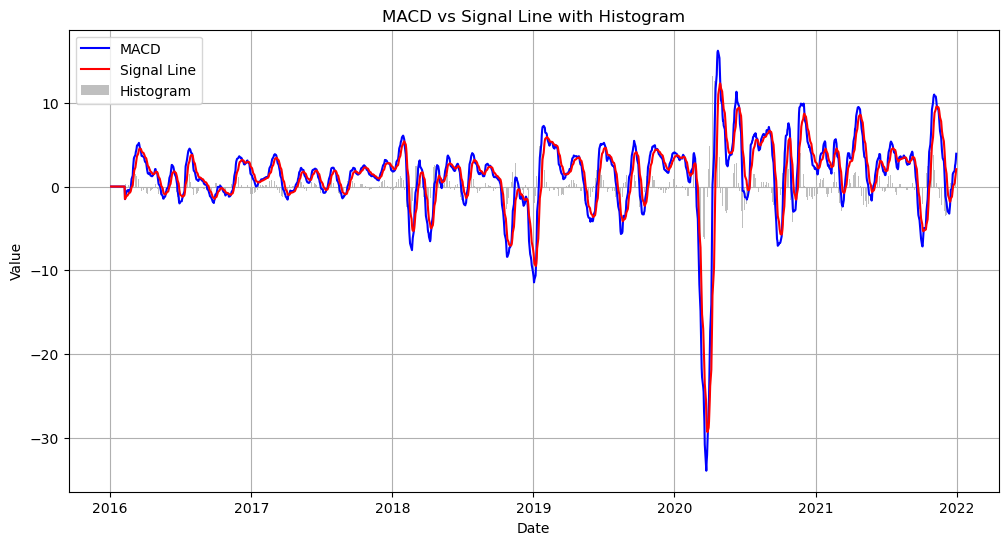

In [6]:
plt.figure(figsize=(12,6))

# Plot MACD Line
plt.plot(new_df.index, new_df['MACD'], label='MACD', color='blue')

# Plot Signal Line
plt.plot(new_df.index, new_df['Signal_Line'], label='Signal Line', color='red')

# Plot Histogram as bars
plt.bar(new_df.index, new_df['Histogram'], label='Histogram', color='gray', alpha=0.5)
# Formatting
plt.legend()
plt.title('MACD vs Signal Line with Histogram')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [7]:
def generate_signals(df, threshold=0.01):
    df['Signal'] = 0  # Default to HOLD

    # Buy when MACD crosses above Signal Line and difference is significant
    df.loc[(df['MACD'] > df['Signal_Line']) & (df['MACD'].shift(1) <= df['Signal_Line'].shift(1)) & 
           (abs(df['MACD'] - df['Signal_Line']) > threshold), 'Signal'] = 1

    # Sell when MACD crosses below Signal Line and difference is significant
    df.loc[(df['MACD'] < df['Signal_Line']) & (df['MACD'].shift(1) >= df['Signal_Line'].shift(1)) & 
           (abs(df['MACD'] - df['Signal_Line']) > threshold), 'Signal'] = -1
generate_signals(new_df)

In [9]:
holdings = 0
buy_list = []  
total_commission = 0
threshold = 0.1 #to counter weak trend reversal
trade_log = []
commission=0.00125
capital = 100000.00

for i, row in new_df.iterrows():
    macd_signal_diff = abs(row['MACD'] - row['Signal_Line'])
    
    # Ignore weak signals
    if macd_signal_diff < threshold:
        continue
    
    # BUY Condition
    if row['Signal'] == 1 and holdings == 0:
        if capital > 0:
            buy_price = row['Close']
            quantity = capital / buy_price  # Buy as many shares as possible
            commission_fee = quantity * buy_price * commission  # Calculate commission
            
            capital -= commission_fee  # Deduct commission
            total_commission += commission_fee
            holdings += quantity  # Increase holdings
            buy_list.append((buy_price, quantity))  # Store buy transaction
            
            trade_log.append({
                'Date': row.name, 'Trade': 'BUY', 'Price': buy_price,
                'Holdings': holdings, 'Capital': capital,
                'Profit': 0, 'Commission_Lost': commission_fee
            })
    
    # SELL Condition
    elif row['Signal'] == -1 and holdings > 0:
        sell_price = row['Close']
        if sell_price < trade_log[-1]['Price']:
            continue
        else:
            sell_value = holdings * sell_price
            commission_fee = sell_value * commission  # Commission on sale
        
            # Calculate profit based on all buy transactions
            total_cost = sum(buy_price * qty for buy_price, qty in buy_list)
            profit = sell_value - total_cost - commission_fee
            
            capital = sell_value - commission_fee  # Update capital
            holdings = 0  # Reset holdings
            buy_list.clear()  # Clear buy records after selling
            total_commission += commission_fee
            
            trade_log.append({
                'Date': row.name, 'Trade': 'SELL', 'Price': sell_price,
                'Holdings': holdings, 'Capital': capital,
                'Profit': profit, 'Commission_Lost': commission_fee
            })

if trade_log[-1]['Trade'] == 'BUY' and holdings > 0:
    last_date = new_df.index[-1]
    last_price = new_df.loc[last_date, 'Close']
    
    sell_value = holdings * last_price
    commission_fee = sell_value * commission
    total_cost = sum(buy_price * qty for buy_price, qty in buy_list)

    profit = sell_value - total_cost - commission_fee
    capital = sell_value - commission_fee
    holdings = 0
    total_commission += commission_fee
    
    trade_log.append({
        'Date': last_date,
        'Trade': 'SELL',
        'Price': last_price,
        'Holdings': holdings,
        'Capital': capital,
        'Profit': profit,
        'Commission_Lost': commission_fee
    })
trade_df = pd.DataFrame(trade_log)
trade_df

,Date,Trade,Price,Holdings,Capital,Profit,Commission_Lost
0,2016-02-10,BUY,185.270004,539.752781,99875.000000,0.000000,125.000000
1,2016-03-21,SELL,204.669998,0.000000,110333.111652,10333.111652,138.089001
2,2016-04-25,BUY,208.610001,528.896560,110195.195262,0.000000,137.916390
3,2016-08-02,SELL,215.550003,0.000000,113861.150499,3528.038847,142.504569
4,2016-09-29,BUY,214.679993,530.376162,113718.824061,0.000000,142.326438
5,2017-06-20,SELL,243.009995,0.000000,128725.599744,14864.449246,161.108385
6,2017-09-05,BUY,246.059998,523.147204,128564.692745,0.000000,160.907000
7,2018-02-02,SELL,275.450012,0.000000,143920.777604,15195.177860,180.126130
8,2018-04-13,BUY,265.149994,542.790047,143740.876632,0.000000,179.900972
9,2018-05-31,SELL,270.940002,0.000000,146879.707193,2958.929588,183.829421


In [10]:
buy_hold_sell = []
commission=0.00125
capital_2 = 100000.00
total_commission_2 = 0
buy_list=[]
holdings = 0

first = new_df.iloc[0]
last = new_df.iloc[-1]

buy_price = first['Close']
quantity = capital_2 / buy_price  # Buy as many shares as possible
commission_fee_2 = quantity * buy_price * commission  # Calculate commission

capital_2 -= commission_fee  # Deduct commission
total_commission_2 += commission_fee_2
holdings += quantity  # Increase holdings
buy_list.append((buy_price, quantity))  # Store buy transaction

new_df.at[i, 'Trade'] = 'BUY'
new_df.at[i, 'Commission_Lost'] = commission_fee

buy_hold_sell.append({
    'Date': first.name, 'Trade': 'BUY', 'Price': buy_price,
    'Holdings': holdings, 'Capital': capital_2,
    'Profit': 0, 'Commission_Lost': commission_fee_2
})

sell_price = last['Close']
sell_value = holdings * sell_price
commission_fee_3 = sell_value * commission  # Commission on sale

# Calculate profit based on all buy transactions
total_cost = sum(buy_price * qty for buy_price, qty in buy_list)
profit = sell_value - total_cost - commission_fee_3

capital_2 = sell_value - commission_fee_3  # Update capital
holdings = 0  # Reset holdings
buy_list.clear()  # Clear buy records after selling
total_commission_2 += commission_fee_3

new_df.at[i, 'Trade'] = 'SELL'
new_df.at[i, 'Profit'] = profit
new_df.at[i, 'Commission_Lost'] = commission_fee_3

buy_hold_sell.append({
    'Date': last.name, 'Trade': 'SELL', 'Price': sell_price,
    'Holdings': holdings, 'Capital': capital_2,
    'Profit': profit, 'Commission_Lost': commission_fee_3
})

buy_hold_sell_df = pd.DataFrame(buy_hold_sell)
buy_hold_sell_df

,Date,Trade,Price,Holdings,Capital,Profit,Commission_Lost
0,2016-01-04,BUY,201.020004,497.462928,99721.800932,0.000000,125.000000
1,2021-12-31,SELL,474.959991,0.000000,235979.644505,135979.644505,295.343735


In [14]:
print(f'Total number of trades on MACD: {len(trade_df)}')

Total number of trades on MACD: 26


In [12]:
avg_return = sum(trade_df['Profit'])/(len(trade_df)/2) #assume average per sell trade
print(f'Average return per sell trade: ${avg_return:.2f}')

Average return per sell trade: $9406.23


In [22]:
bhs = buy_hold_sell_df.iloc[1]['Capital']
macd = trade_df.iloc[-1]['Capital']
print(f'The amount earned from buy hold sell strategy: ${bhs:.2f}\nThe amount earned from MACD trading: ${macd:.2f}')
if bhs < macd:
    print(f'MACD trading earned more than the buy hold sell strategy by {macd-bhs:.2f}')
elif bhs > macd:
    print(f'buy hold sell strategy earned more than MACD trading by ${bhs-macd:.2f}')

The amount earned from buy hold sell strategy: $235979.64
The amount earned from MACD trading: $222281.05
buy hold sell strategy earned more than MACD trading by $13698.59
